# geotiff2csv 

Extraire une portion de GeoTiff en utilisant la librairie Gdal.

## Introduction

Le **GeoTiff** est un format d'image fréquemment utilisé pour stocker des **données géo-référencées**. 

Le format GeoTiff est, par exemple, utilisé pour la mise à disposition de [Corine Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover)(**CLC**).

Dans le cas de CLC, à chaque **Pixel** de l'image correspond un **hectare** de terrain. A chaque Pixel est associé un code. Dans le cas de CLC, il s'agit d'un code d'occupation du sol (Land Use).

CLC couvre 39 états. Les fichiers GeoTiff fournis par l'Agence Européenne de l'environnement sont très gros. Il y a un fichier par année. Chaque fichier fait environ 200 MB.

Un GeoTiff est une image qui peut facilement être importée sous la forme d'une **matrice**. Dans le cas de CLC, la matrice est énorme puisqu'elle compte **65.000 lignes** pour **46.000 colonnes**, ce qui fait 65.000 * 46.000 = 2.99 milliards de pixels! Il s'agit vraiment d'une très grosse matrice!

Nous ne nous intéressons, pour l'instant, qu'aux données belges. L'idée est d'extraire de cette grosse matrice, une sous-matrice qui comporte tous les pixels relatifs à la Belgique. Nous aurons, bien sûr, dans notre sous-matrice, quelques éléments (pixels) qui ne concernent pas la Belgique, puisque notre pays n'a pas une forme "rectangulaire".

Pour extraire des informations d'un GeoTiff, nous pouvons utiliser la librairie  [Gdal](https://en.wikipedia.org/wiki/GDAL).

## Tiff

Le Tiff est un format pour le stockage d'images matricielles. On parle aussi de "raster" en anglais. Voici une image extraite de Wikipédia et qui montre différents éléments (ou pixels) qui composent une image matricielle.

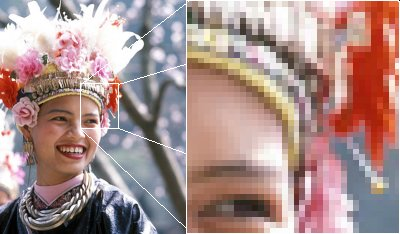


## GeoTiff

Un GeoTiff est une image au format Tiff auquel on a ajouté des **méta-données de géo-référencement**. De la documentation sur le *format GeoTiff* est disponible à l'adresse [https://www.gdal.org/frmt_gtiff.html](https://www.gdal.org/frmt_gtiff.html). 

Lorsque nous importons un GeoTiff en Python, nous obtenons une matrice. L'élément de la matrice situé à l'intersection de la $L^{ème}$ ligne et de la $P^{ème}$ colonne est identifié à l'aide du couple $(L,P)$.

Les méta-données stockées dans les fichiers Corine Land Cover nous permettent de transformer un couple $(L,P)$ en coordonnées géographiques $(X,Y)$. Nous ferons en sorte que ces coordonnées correspondent au centroïde de l'hectare correspondant au pixel situé en $(L,P)$. 

Le système de projection utilisé par CLC est l'ETRS89 LAEA. **LAEA** est un acronyme pour **Lambert Azimuthal Equal Area**.



## Géoréférencement

Le géoréférencement est l'action qui consiste à associer les coordonnées $(L,P)$ aux coordonnées $(X,Y)$.

## Gdal

Pour extraire des informations d'un GeoTiff, nous pouvons utiliser la librairie  [Gdal](https://en.wikipedia.org/wiki/GDAL). Il s'agit d'une librairie qui est utilisée par un très grand nombre de logiciels (ArcGis, QGis, ...). 

La documentation est disponible à l'adresse [https://www.gdal.org/classGDALDataset.html](https://www.gdal.org/classGDALDataset.html).

Fonction intéressantes du package Gdal (pas toutes utilisées ic):


* myRaster.GetProjectionRef()
* myRaster.RasterCount
* myBand=myRaster.GetRasterBand(1)
* myBand.DataType
* myBand.XSize,myBand.YSize
* myRaster.GetGeoTransform()
* myBand.GetNoDataValue()



## Bounding box

Nous pouvons utiliser [BBox finder](http://bboxfinder.com/#49.425267,2.427979,51.553167,6.553345) pour identifier un rectangle qui entoure la Belgique (ou une autre unité administrative). 

Exemple de Bounding Boxes:
- Belgium: **(3795050, 2939950)->(4067050, 3169950)**
- Rixensart: **(3919063,3067640)->(3952705,3091820)**

# Paramètres

In [1]:
# Input files

CorineGeoTiffDirectory='/home/yoba/DataScience/data/Open-Data/clc'

CorineGeoTiff={
               1990:'{}/1990/CLC1990_CLC1990_V2018_20b2.tif'.format(CorineGeoTiffDirectory),
               2000:'{}/2000/CLC2006_CLC2000_V2018_20b2.tif'.format(CorineGeoTiffDirectory),
               2006:'{}/2006/CLC2012_CLC2006_V2018_20b2.tif'.format(CorineGeoTiffDirectory),
               2012:'{}/2012/CLC2018_CLC2012_V2018_20b2.tif'.format(CorineGeoTiffDirectory),
               2018:'{}/2018/clc2018_clc2018_V2018.20b2.tif'.format(CorineGeoTiffDirectory)
              }

# Bounding box

x1,y1=3795050,2939950
x2,y2=4067050,3169950

# Output directory

CorineCsvDirectory='/home/yoba/DataScience/data/StatisticalProducts/clc/bbox'


# Imports

In [2]:
import numpy as np
import pandas as pd
from osgeo import gdal
from numpy.linalg import inv


# Fonctions

## Transformer des (X,Y) en (L,P)

In [3]:
def xy2pixel(padfTransform,Xp,Yp)-> '(pixel,line) coordinates':
    """
    Transforming projection coordinates (Xp,Yp) to pixel/line (P,L) raster space.
    """
    
    pixel2xy=np.array([[padfTransform[1], padfTransform[2]], 
                       [padfTransform[4], padfTransform[5]]])
    
    xy2pixel=inv(pixel2xy)
    
    a = np.matmul(xy2pixel,np.array([[Xp-padfTransform[0]],
                                     [Yp-padfTransform[3]]]))
    
    result=(a-np.array([[0.5],[0.5]])).tolist()
    
    return {'pixel':int(result[0][0]),'line':int(result[1][0])}


## Transformer des (L,P) en (X,Y) 

In [4]:
def pixel2xy(padfTransform,P:'pixel (column)',L:'line')->'(x,y) coordinates':
    """
    Transforming pixel/line (P,L) raster space to projection coordinates (Xp,Yp).
    
    In a north up image, padfTransform[1] is the pixel width, and padfTransform[5] 
    is the pixel height.     The upper left corner of the upper left pixel is at 
    position (padfTransform[0],padfTransform[3]).
    
    The padTransform vector is stored in the metadata portion of the geoTiff. We can 
    extract it using the GetGetTransform() method.
    """
    
    Xp = padfTransform[0] + (P+0.5) * padfTransform[1] + (L+0.5) * padfTransform[2]
    Yp = padfTransform[3] + (P+0.5) * padfTransform[4] + (L+0.5) * padfTransform[5]
    
    return (Xp,Yp)   


In [5]:
def geotiff2csv(year):
    
    inputFile=CorineGeoTiff[year]
    
    outputFile=f'{CorineCsvDirectory}/clc-({x1},{y1})-({x2},{y2})-{year}.csv'
    
    # Opening a GeoTiff does not import it into memory. In the end, we have a "link"
    myRaster = gdal.Open(inputFile)
    
    # "Connect" to first band - There is only one band in CLC files
    myBand=myRaster.GetRasterBand(1)
    
    # Identify portion of geotiff to extract
    lowerLeftCorner =xy2pixel(myRaster.GetGeoTransform(),x1,y1)
    upperRightCorner=xy2pixel(myRaster.GetGeoTransform(),x2,y2)
    
    # Extract
    pixelOffset     = lowerLeftCorner['pixel']
    pixelWindowSize = upperRightCorner['pixel']-lowerLeftCorner['pixel']
    lineOffset      = upperRightCorner['line']
    lineWindowSize  = lowerLeftCorner['line']-upperRightCorner['line']
    
    myBBox=myBand.ReadAsArray(xoff      = pixelOffset     , 
                              yoff      = lineOffset      , 
                              win_xsize = pixelWindowSize , 
                              win_ysize = lineWindowSize  )
    
    # Get rid of "No Data" values
    L,P       = np.where(  myBBox != myBand.GetNoDataValue()        )
    data_vals = np.extract(myBBox != myBand.GetNoDataValue(), myBBox)

    # Transform (P,L) to (X,Y) coordinates 
    XY=pixel2xy(myRaster.GetGeoTransform(),pixelOffset+P,lineOffset+L)
    
    # Export results
    myDataFrame=pd.DataFrame({'X':XY[0],'Y':XY[1],'VALUE':data_vals})
    myDataFrame.to_csv(outputFile,index=False,sep='|')
    

# Functions calls

In [6]:
for y in [1990,2000,2006,2012,2018]:
    geotiff2csv(y)
    